# Analyzing seasonality on the GS off cape hatteras

In [1]:
# Data manipulation
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr

# time
import datetime

# downloading data from GDrive
# from google_drive_downloader import GoogleDriveDownloader as gdd

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import hvplot.xarray
import hvplot.pandas
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# geographic and geometry tools
import cartopy.crs as crs
from shapely.ops import unary_union
from shapely.ops import transform
from shapely.geometry import Polygon
from affine import Affine

# there are many divide by zero warnings that we're going to suppress
# but advised to comment this line out when actively coding
import warnings
warnings.filterwarnings('ignore')

In [3]:
chla_ds = xr.open_zarr('data/chla_long.zarr')
chla_ds

<xarray.Dataset>
Dimensions:  (lat: 432, lon: 384, time: 714)
Coordinates:
  * lat      (lat) float64 43.98 43.94 43.9 43.85 ... 26.15 26.1 26.06 26.02
  * lon      (lon) float64 -81.98 -81.94 -81.9 -81.85 ... -66.1 -66.06 -66.02
  * time     (time) datetime64[ns] 2010-04-01 2010-04-06 ... 2019-12-27
Data variables:
    chlor_a  (time, lat, lon) float32 dask.array<chunksize=(238, 218, 320), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                       CF-1.7
    Metadata_Conventions:              Unidata Dataset Discovery v1.0
    _NCProperties:                     version=1|netcdflibversion=4.4.1.1|hdf...
    cdm_data_type:                     Grid
    comment:                           See summary attribute
    creation_date:                     Tue Feb  2 11:54:34 2021
    ...                                ...
    time_coverage_duration:            P5D
    time_coverage_end:                 202012302359Z
    time_coverage_resolution:          P5D
    time_coverage_start:               202012260000Z
    title:                             ESA CCI Ocean Colour Product
    tracking_id:                       2a3b7595-7123-4795-8013-71659996a2d8

### make my map for the GS paper

In [5]:
import cmocean

In [6]:
plt.rcParams.update({'font.size': 18})

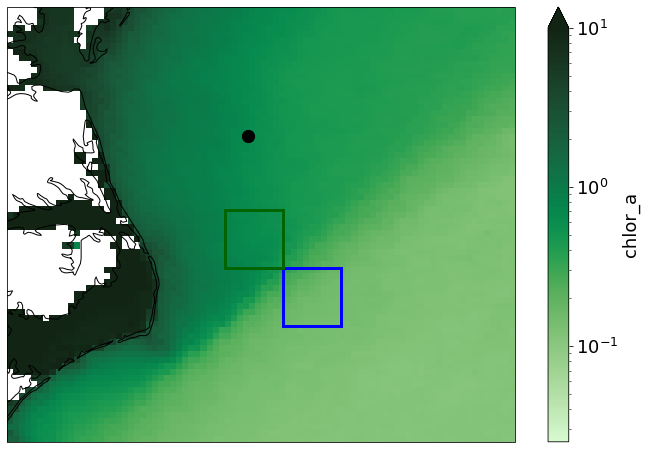

In [9]:
fig,ax = plt.subplots(figsize=(12,8),subplot_kw=dict(projection=crs.PlateCarree()))

chla_ds.chlor_a[365:365+365].mean(dim='time', skipna=True).plot(ax=ax, cmap=cmocean.cm.algae, norm=LogNorm(vmin=0.025, vmax=10))

# (sst_ds.analysed_sst[365:365+365].mean(dim='time', skipna=True)-273.15).plot(ax=ax, vmin=284-273.15, vmax=300-273.15, cmap=cmocean.cm.thermal)
# ssh_ds.adt[0:365].median(dim='time', skipna=True).plot(ax=ax, vmin=-1, vmax=1, cmap='bwr')
# ax.set_title('Mean SST of the Gulf Stream')

ax.coastlines(resolution='10m')

import matplotlib.patches as patches

# Create a Rectangle patch
rect = patches.Rectangle((-74.6, 35.3), .4, .4, linewidth=3, edgecolor='b', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

ax.scatter(-74.842, 36.609,c='black',s=150)

# Create a Rectangle patch
rect = patches.Rectangle((-75.0, 35.7), .4, .4, linewidth=3, edgecolor='darkgreen', facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)

ax.set_ylim(34.5,37.5)
ax.set_xlim(-76.5,-73)

plt.savefig('location_of_mean_areas_chla.png',dpi=300)
plt.show()

Investigating the SST from Feb and March

https://aws.amazon.com/marketplace/pp/prodview-kvgy4vkuhavsc

In [40]:
sst_ds_mur = xr.open_dataset('data/20220201090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
sst_ds_mur = sst_ds_mur.sel(lat=slice(26,44),lon=slice(-82,-66))
sst_ds_mur

<xarray.Dataset>
Dimensions:           (lat: 1801, lon: 1601, time: 1)
Coordinates:
  * time              (time) datetime64[ns] 2022-02-01T09:00:00
  * lat               (lat) float32 26.0 26.01 26.02 26.03 ... 43.98 43.99 44.0
  * lon               (lon) float32 -82.0 -81.99 -81.98 ... -66.02 -66.01 -66.0
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
    dt_1km_data       (time, lat, lon) timedelta64[ns] ...
    sst_anomaly       (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid

In [15]:
df = pd.DataFrame(
    {'info': ['study area coastal', 'study area gs'],
     'Latitude': [36.83,36.81],
     'Longitude': [-74.76, -74.65]})

gdf_feb = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

df = pd.DataFrame(
    {'info': ['study area coastal', 'study area gs'],
     'Latitude': [36.30,36.22],
     'Longitude': [-74.74, -74.66]})

gdf_march = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

### Sea Surface Temperature
via NOAA and the Group for High Resolution Sea Surface Temperature (GHRSST).

In [7]:
sst_ds = xr.open_zarr('data/sst.zarr')
sst_ds

<xarray.Dataset>
Dimensions:       (lat: 360, lon: 320, time: 1089)
Coordinates:
  * lat           (lat) float32 26.02 26.08 26.12 26.17 ... 43.88 43.92 43.97
  * lon           (lon) float32 -81.97 -81.93 -81.88 ... -66.12 -66.07 -66.03
  * time          (time) datetime64[ns] 2017-01-01T12:00:00 ... 2019-12-31T12...
Data variables:
    analysed_sst  (time, lat, lon) float32 dask.array<chunksize=(200, 360, 320), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.4, Unidata Observation Dataset v1.0
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             NOAA/NESDIS
    cdm_data_type:              grid
    comment:                    The Geo-Polar Blended Sea Surface Temperature...
    creator_email:              john.sapper@noaa.gov
    ...                         ...
    summary:                    An SST estimation scheme which combines multi...
    time_coverage_end:          20191231T000000Z
    time_coverage_start:        20191230T000000Z
    title:                      Analysed blended sea surface temperature over...
    uuid:                       ce60c901-9989-40f1-8457-b4963ceb55b0
    westernmost_longitude:      -180.0

Let's take a quick look at a static and interactive plot of SST

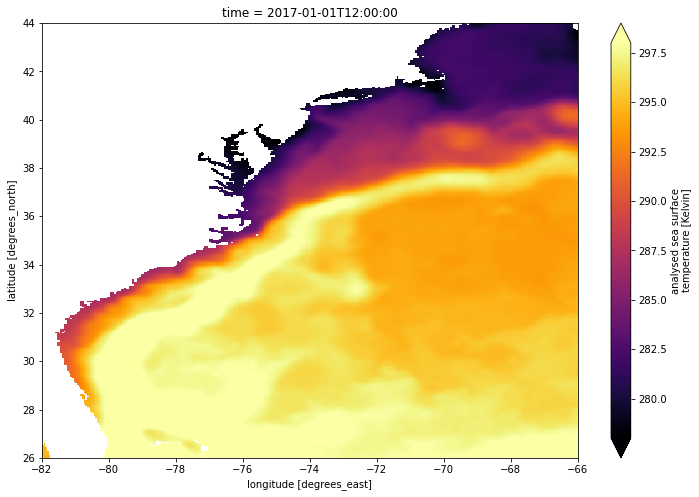

In [8]:
fig,ax = plt.subplots(figsize=(12,8))
sst_ds.analysed_sst[0].plot(ax=ax, vmin=278, vmax=298, cmap='inferno')

Now let's take the mean of a year of daily SST data just to clearly see the thermal footprint of the Gulf Stream

Text(0.5, 1.0, 'Mean SST of the Gulf Stream')

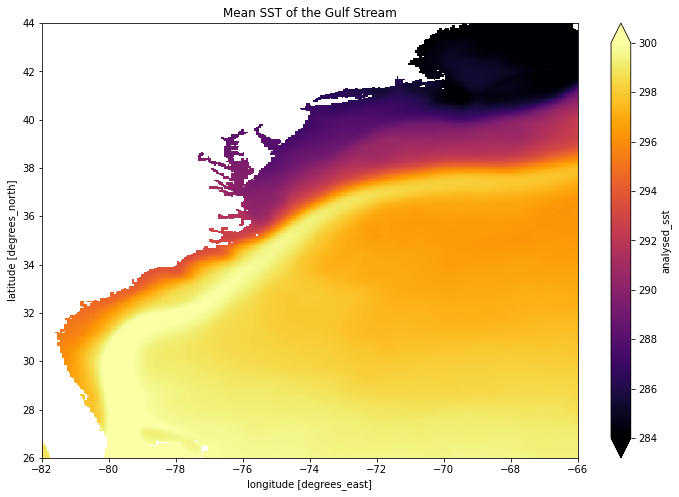

In [18]:
fig,ax = plt.subplots(figsize=(12,8))
sst_ds.analysed_sst[0:365].mean(dim='time', skipna=True).plot(ax=ax, vmin=284, vmax=300, cmap='inferno')
ax.set_title('Mean SST of the Gulf Stream')

### plot out the boxes we use for long term analysis to show their location

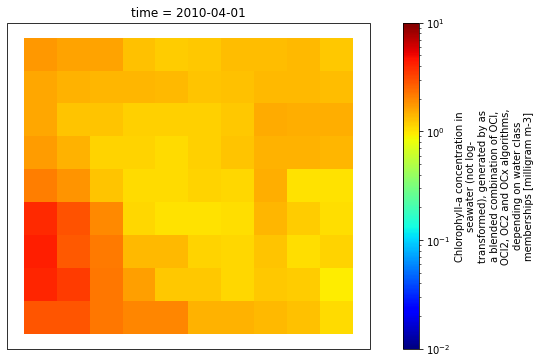

In [9]:
chla_ds_cut_gs = chla_ds.sel(lat=slice(35.7,35.3),lon=slice(-75.0,-74.6))
chla_ds_cut_gs.chlor_a[30].plot(ax=ax, cmap='jet', norm=LogNorm(vmin=0.01, vmax=10))
plt.show()

fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

chla_ds_cut_slope = chla_ds.sel(lat=slice(36.1,35.7),lon=slice(-75.4,-75.0))
chla_ds_cut_slope.chlor_a[0].plot(ax=ax, cmap='jet', norm=LogNorm(vmin=0.01, vmax=10))
plt.show()

### Look at averages from the coastal and GS side of the general area of our frontal eddy

so I want to subset to my area and then look at the seasonal patterns over the course of the year

In [40]:
import cmocean

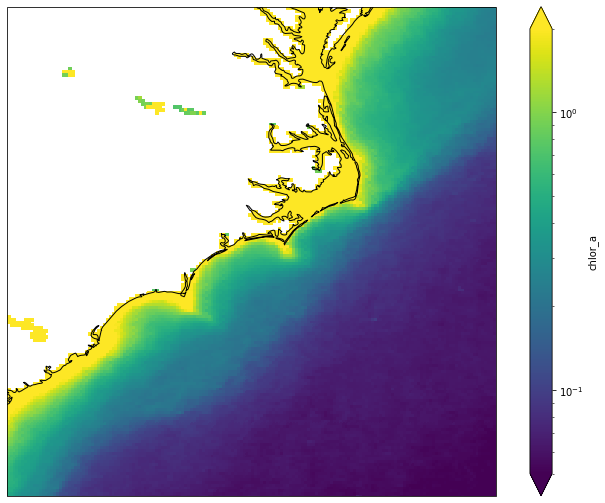

In [45]:
fig, ax = plt.subplots(figsize=(12,9), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

ax.set_ylim(31,38)
ax.set_xlim(-80.5,-73.5)

# chla_ds = chla_ds.sel(lat=slice(44,26),lon=slice(-82,-66))
# chla_ds.groupby("time.month").mean(dim="time")

chla_ds.groupby("time.month").mean(dim="time").chlor_a[7:9,:,:].mean(dim="month").plot(ax=ax, cmap='viridis', norm=LogNorm(vmin=0.05, vmax=2))
plt.savefig('average_chla_aug_sept.png',dpi=300)

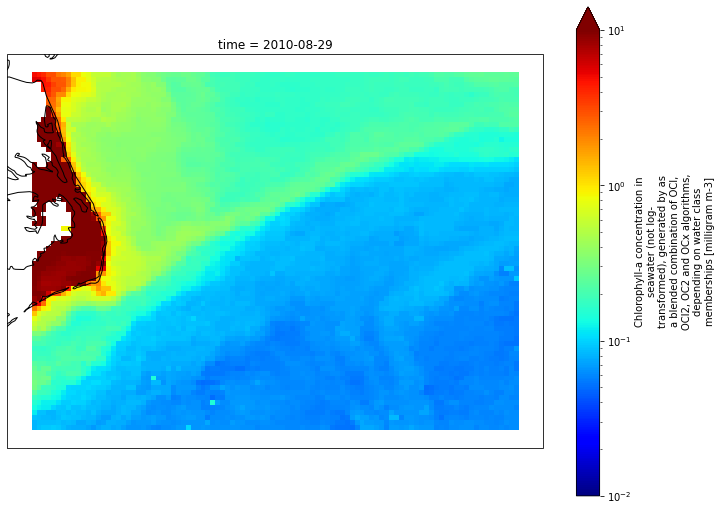

In [70]:
fig, ax = plt.subplots(figsize=(12,9), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

chla_ds_cut = chla_ds.sel(lat=slice(37,34),lon=slice(-76.1,-72))
chla_ds_cut.chlor_a[30].plot(ax=ax, cmap='jet', norm=LogNorm(vmin=0.01, vmax=10))

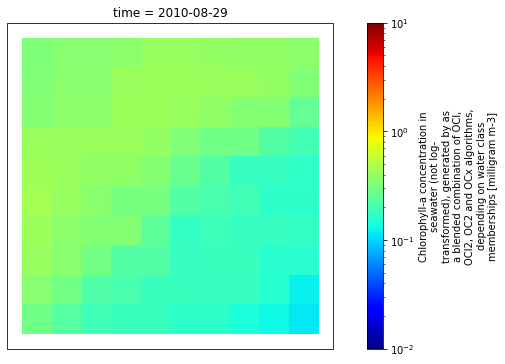

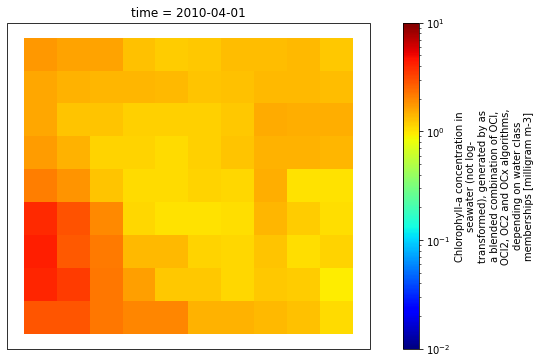

In [11]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

chla_ds_cut_gs = chla_ds.sel(lat=slice(35.7,35.3),lon=slice(-75.0,-74.6))
chla_ds_cut_gs.chlor_a[30].plot(ax=ax, cmap='jet', norm=LogNorm(vmin=0.01, vmax=10))
plt.show()

fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

chla_ds_cut_slope = chla_ds.sel(lat=slice(36.1,35.7),lon=slice(-75.4,-75.0))
chla_ds_cut_slope.chlor_a[0].plot(ax=ax, cmap='jet', norm=LogNorm(vmin=0.01, vmax=10))
plt.show()

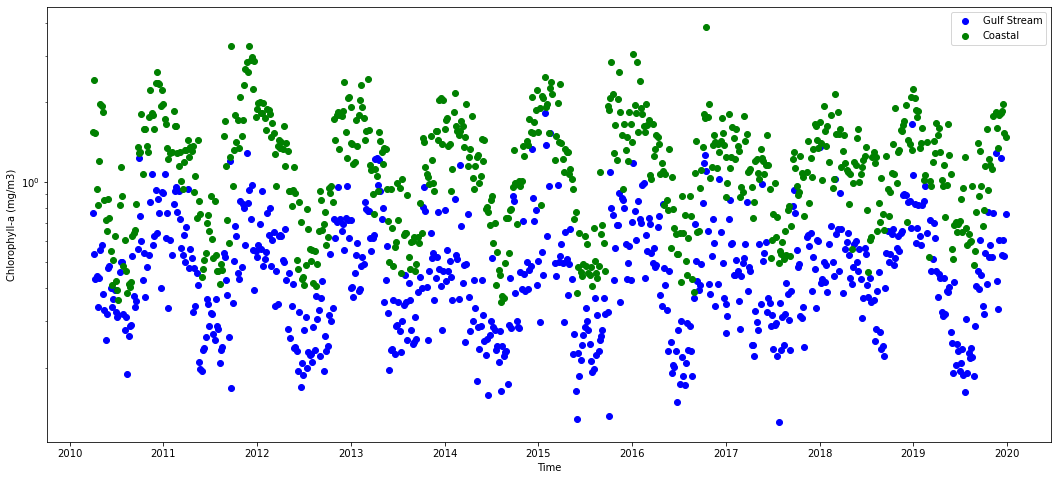

In [18]:
fig, ax = plt.subplots(figsize=(18,8))
chla_ds_cut_gs.mean(dim=['lat','lon']).plot.scatter(x="time", y="chlor_a",ax=ax, color='blue', label='Gulf Stream')
# chla_ds_cut_gs.median(dim=['lat','lon']).chlor_a.plot(ax=ax, color='blue')

# ax2 = ax.twinx()

chla_ds_cut_slope.mean(dim=['lat','lon']).plot.scatter(x="time", y="chlor_a",ax=ax, color='green', label='Coastal')
# chla_ds_cut_slope.median(dim=['lat','lon']).chlor_a.plot(ax=ax, color='green')

# ax.fill_between(pd.to_datetime(chla_ds_cut_gs.median(dim=['lat','lon']).time.values), chla_ds_cut_gs.median(dim=['lat','lon']).chlor_a.fillna(1)- chla_ds_cut_gs.std(dim=['lat','lon']).chlor_a.fillna(0)  , chla_ds_cut_gs.median(dim=['lat','lon']).chlor_a.fillna(1)+chla_ds_cut_gs.std(dim=['lat','lon']).chlor_a.fillna(0), color='grey', alpha=0.5)
# ax.fill_between(pd.to_datetime(chla_ds_cut_slope.median(dim=['lat','lon']).time.values), chla_ds_cut_slope.median(dim=['lat','lon']).chlor_a.fillna(1)-chla_ds_cut_slope.std(dim=['lat','lon']).chlor_a.fillna(0), chla_ds_cut_slope.median(dim=['lat','lon']).chlor_a.fillna(1)+chla_ds_cut_slope.std(dim=['lat','lon']).chlor_a.fillna(0), color='grey', alpha=0.5)

ax.set_yscale('log')

ax.set_ylabel('Chlorophyll-a (mg/m3)')
ax.set_xlabel('Time')

# ax.set_xlim(sst_ds_cut_gs.time.min().values, sst_ds_cut_gs.time.max().values)

ax.legend(loc='upper right')
# ax2.legend(loc='upper left')

# plt.savefig('chla_gs_coastal.png',dpi=300)

Text(0.5, 0, 'Day of Year')

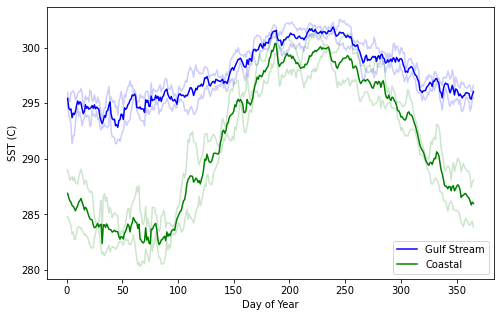

In [23]:
fig,ax = plt.subplots(figsize=(8,5))

dates_x = np.arange(1,366,1)

####################

data = sst_ds_cut_gs.median(dim=['lat','lon']).analysed_sst.values
dates = sst_ds_cut_gs.indexes['time']
gs_df = pd.Series(data, dates, name='gs_sst')

sst_mean = gs_df.groupby([gs_df.index.month, gs_df.index.day]).mean()
test_std = gs_df.groupby([gs_df.index.month, gs_df.index.day]).std()

ax.plot(dates_x,sst_mean, c='blue', label='Gulf Stream')
ax.plot(dates_x,sst_mean+test_std, c='blue', alpha=0.2)
ax.plot(dates_x,sst_mean-test_std, c='blue', alpha=0.2)

###################

data = sst_ds_cut_slope.median(dim=['lat','lon']).analysed_sst.values
dates = sst_ds_cut_slope.indexes['time']
coastal_df = pd.Series(data, dates, name='coastal_sst')

sst_mean = coastal_df.groupby([coastal_df.index.month, coastal_df.index.day]).mean()
test_std = coastal_df.groupby([coastal_df.index.month, coastal_df.index.day]).std()

ax.plot(dates_x,sst_mean, c='green', label='Coastal')
ax.plot(dates_x,sst_mean+test_std, c='green', alpha=0.2)
ax.plot(dates_x,sst_mean-test_std, c='green', alpha=0.2)

################3

ax.legend(loc='lower right')

ax.set_ylabel('SST (C)')
ax.set_xlabel('Day of Year')

In [160]:
df = pd.concat([coastal_df, gs_df], axis=1)
df.to_csv('sst_gs_coastal.csv')

In [140]:
str_dts = []
for i in range(len(sst_mean.index)):
    str_dts.append(str(sst_mean.index[i][1])+','+str(sst_mean.index[i][0]))

In [141]:
day_of_year_chla = [datetime.datetime.strptime(dt,"%d,%m").timetuple().tm_yday for dt in str_dts]

Text(0.5, 0, 'Day of Year')

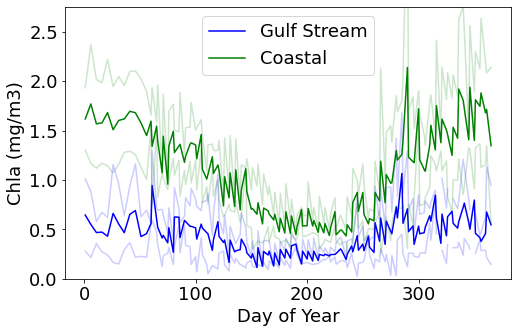

In [150]:
fig,ax = plt.subplots(figsize=(8,5))

dates_x = day_of_year_chla

####################

data = chla_ds_cut_gs.median(dim=['lat','lon']).chlor_a.values
dates = chla_ds_cut_gs.indexes['time']
gs_df = pd.Series(data, dates, name='gs_chla')

sst_mean = gs_df.groupby([gs_df.index.month, gs_df.index.day]).mean()
test_std = gs_df.groupby([gs_df.index.month, gs_df.index.day]).std()

ax.plot(dates_x,sst_mean, c='blue', label='Gulf Stream')
ax.plot(dates_x,sst_mean+test_std, c='blue', alpha=0.2)
ax.plot(dates_x,sst_mean-test_std, c='blue', alpha=0.2)

###################

data = chla_ds_cut_slope.median(dim=['lat','lon']).chlor_a.values
dates = chla_ds_cut_slope.indexes['time']
coastal_df = pd.Series(data, dates, name='coastal_chla')

sst_mean = coastal_df.groupby([coastal_df.index.month, coastal_df.index.day]).mean()
test_std = coastal_df.groupby([coastal_df.index.month, coastal_df.index.day]).std()

ax.plot(dates_x,sst_mean, c='green', label='Coastal')
ax.plot(dates_x,sst_mean+test_std, c='green', alpha=0.2)
ax.plot(dates_x,sst_mean-test_std, c='green', alpha=0.2)

################3

ax.set_ylim(0,2.75)

ax.legend()

ax.set_ylabel('Chla (mg/m3)')
ax.set_xlabel('Day of Year')

In [151]:
df = pd.concat([coastal_df, gs_df], axis=1)
df.to_csv('chla_gs_coastal.csv')

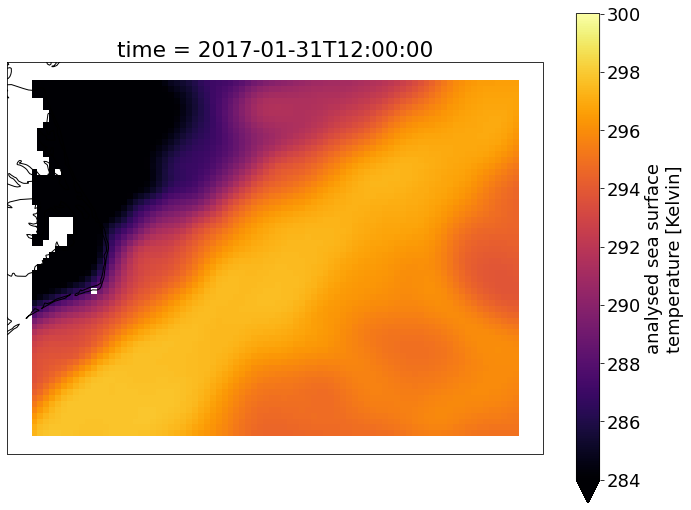

In [131]:
fig, ax = plt.subplots(figsize=(12,9), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

sst_ds_cut = sst_ds.sel(lat=slice(34,37),lon=slice(-76.1,-72))
sst_ds_cut.analysed_sst[30].plot(ax=ax, vmin=284, vmax=300, cmap='inferno')

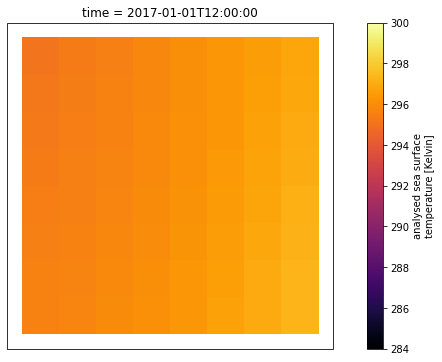

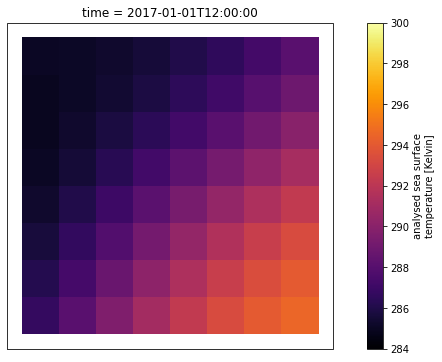

In [17]:
fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

sst_ds_cut_gs = sst_ds.sel(lat=slice(35.3,35.7),lon=slice(-75.0,-74.6))
sst_ds_cut_gs.analysed_sst[0].plot(ax=ax,  vmin=284, vmax=300, cmap='inferno')
plt.show()

fig, ax = plt.subplots(figsize=(12,6), subplot_kw=dict(projection=crs.PlateCarree()))
ax.coastlines(resolution='10m')

sst_ds_cut_slope = sst_ds.sel(lat=slice(35.7,36.1),lon=slice(-75.4,-75.0))
sst_ds_cut_slope.analysed_sst[0].plot(ax=ax,  vmin=284, vmax=300, cmap='inferno')
plt.show()

(6210.5, 7304.5)

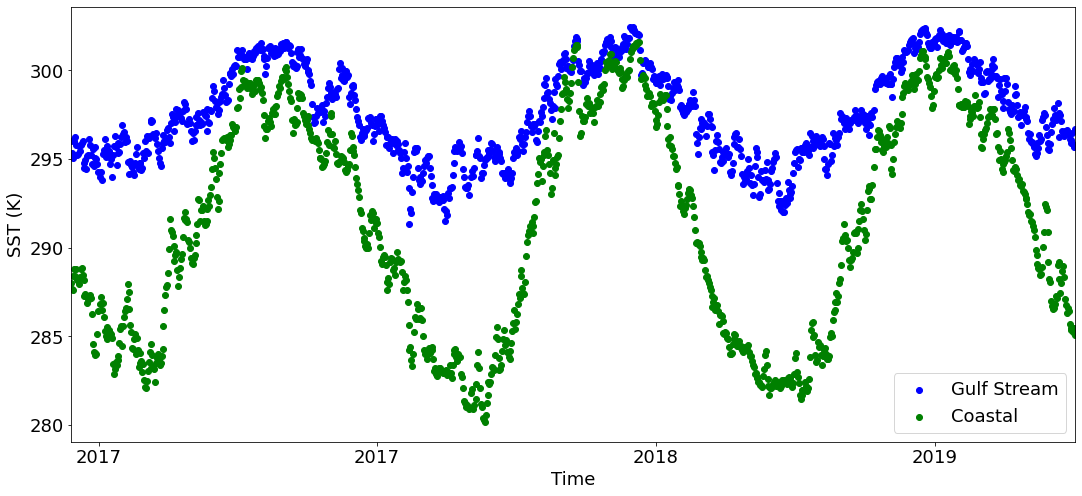

In [32]:
fig, ax = plt.subplots(figsize=(18,8))

sst_ds_cut_gs.median(dim=['lat','lon']).plot.scatter(x="time", y="analysed_sst",ax=ax, color='blue', label='Gulf Stream')
# sst_ds_cut_gs.median(dim=['lat','lon']).analysed_sst.plot(ax=ax, color='blue')

# ax.fill_between(pd.to_datetime(sst_ds_cut_gs.median(dim=['lat','lon']).time.values), sst_ds_cut_gs.median(dim=['lat','lon']).analysed_sst-sst_ds_cut_gs.std(dim=['lat','lon']).analysed_sst, sst_ds_cut_gs.median(dim=['lat','lon']).analysed_sst+sst_ds_cut_gs.std(dim=['lat','lon']).analysed_sst, color='grey', alpha=0.5)
# ax.fill_between(pd.to_datetime(sst_ds_cut_slope.median(dim=['lat','lon']).time.values), sst_ds_cut_slope.median(dim=['lat','lon']).analysed_sst-sst_ds_cut_slope.std(dim=['lat','lon']).analysed_sst, sst_ds_cut_slope.median(dim=['lat','lon']).analysed_sst+sst_ds_cut_slope.std(dim=['lat','lon']).analysed_sst, color='grey', alpha=0.5)



# ax2 = ax.twinx()

sst_ds_cut_slope.median(dim=['lat','lon']).plot.scatter(x="time", y="analysed_sst",ax=ax, color='green', label='Coastal')
# sst_ds_cut_slope.median(dim=['lat','lon']).analysed_sst.plot(ax=ax, color='green')

ax.set_ylabel('SST (K)')
ax.set_xlabel('Time')

ax.legend(loc='lower right')
# ax2.legend(loc='upper left')

ax.set_xlim(sst_ds_cut_gs.time.min().values, sst_ds_cut_gs.time.max().values)


# plt.savefig('sst_gs_coastal.png',dpi=300)
